# Censoring 

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import relativedelta
import time
import matplotlib.pyplot as plt
import matplotlib
plt.set_cmap('bone')
import seaborn as sns
from geopy import distance
from sklearn.cluster import DBSCAN
import time
import re
import folium
from matplotlib.ticker import MaxNLocator
from tqdm.notebook import tqdm
from IPython.display import display
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import math

cmap = plt.cm.bone
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

### Importing data

In [4]:
lastdata = '11052021'

In [114]:
df = pd.read_csv('df_' + lastdata + '.csv')
df = df.drop(columns = 'Unnamed: 0')
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

df.head(3)

,Station Name,MAC Address,Start Date,End Date,Total Duration (mins),Charging Time (mins),Energy (kWh),Port Number,Plug Type,Latitude,Longitude,Fee (USD),Label,CenterLat,CenterLon
0,PALO ALTO CA / HAMILTON #1,000D6F00015A9D76,2011-07-29 20:17:00,2011-07-29 23:20:00,183.533333,114.050000,6.249457,2,J1772,37.444572,-122.160309,0.0,2,37.444544,-122.160258
1,PALO ALTO CA / HAMILTON #1,000D6F00015A9D76,2011-07-30 00:00:00,2011-07-30 00:02:00,2.100000,1.900000,0.106588,2,J1772,37.444572,-122.160309,0.0,2,37.444544,-122.160258
2,PALO ALTO CA / HAMILTON #1,000D6F00015A9D76,2011-07-30 08:16:00,2011-07-30 12:34:00,257.533333,257.466667,14.951777,2,J1772,37.444572,-122.160309,0.0,2,37.444544,-122.160258


In [115]:
plugdf = pd.read_csv('plugdf_' + lastdata + '.csv')
plugdf = plugdf.rename(columns = {'Unnamed: 0': 'Date'})
plugdf['Date'] = pd.to_datetime(plugdf['Date'])
plugdf = plugdf.set_index('Date')
#p2 = p2.drop(columns = 'Unnamed: 0')
plugdf.head()

,Label,Plugs_raw,Number of NEMA 5-20R_raw,Plugs,Number of NEMA 5-20R
Date,,,,,
2011-10-10,0,2.0,1.0,2.0,1.0
2011-10-11,0,2.0,1.0,2.0,1.0
2011-10-12,0,2.0,1.0,2.0,1.0
2011-10-13,0,4.0,2.0,4.0,2.0
2011-10-14,0,4.0,2.0,4.0,2.0


In [116]:
df_days_with_external = pd.read_csv('df_days_with_external_' + lastdata + '.csv')
df_days_with_external['Date'] = pd.to_datetime(df_days_with_external['Date'])
#df['Start Date'] = pd.to_datetime(df['Start Date'])
#df['End Date'] = pd.to_datetime(df['End Date'])


In [117]:
df_days_with_external

,Date,Label,Charging Time (mins),Parking Time (mins),Energy (kWh),Fee (USD),# Food,# Shop & Service,# Professional & Other Places,# Nightlife Spot,...,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,Holiday,Days_previous_holiday,Days_next_holiday
0,2011-07-29,2,114.050000,183.533333,6.249457,0.000000,127.0,99.0,86,87.0,...,0,1,0,0,0,0,0,0,25,38
1,2011-07-30,2,517.200000,686.650000,28.978653,0.000000,127.0,99.0,86,87.0,...,0,1,0,0,0,0,0,0,26,37
2,2011-07-31,2,647.866667,725.983333,37.209163,0.000000,127.0,99.0,86,87.0,...,0,1,0,0,0,0,0,0,27,36
3,2011-08-01,2,95.133333,203.566667,5.041244,0.000000,127.0,99.0,86,87.0,...,0,0,1,0,0,0,0,0,28,35
4,2011-08-02,2,279.983333,280.316667,16.210423,0.000000,127.0,99.0,86,87.0,...,0,0,1,0,0,0,0,0,29,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24619,2019-12-27,0,1320.766667,1501.966667,100.728000,24.500000,132.0,105.0,83,69.0,...,0,0,0,0,0,0,1,0,2,5
24620,2019-12-28,0,545.383333,620.633333,46.182000,11.000000,132.0,105.0,83,69.0,...,0,0,0,0,0,0,1,0,3,4
24621,2019-12-29,0,755.300000,971.516667,61.271000,15.090000,132.0,105.0,83,69.0,...,0,0,0,0,0,0,1,0,4,3
24622,2019-12-30,0,1766.329655,1999.293908,137.772290,31.688414,132.0,105.0,83,69.0,...,0,0,0,0,0,0,1,0,5,2


## When are all plugs at a cluster occupied and thereby generating latent demand? 

In [26]:
def create_month_buckets(startmin, startmax): 
    startmonth = pd.to_datetime(str(startmin.year) +'-'+ str(startmin.month))
    endmonth = pd.to_datetime(str(startmax.year) +'-'+ str(startmax.month))
    
    months = pd.date_range(startmonth, endmonth, freq='MS')
    
    return months 

In [27]:
def active_plugs(df, label, plugdf): 
    df_active = df.copy()
    df_active = df_active[df_active['Label'] == label]
    df_active = df_active[['Start Date', 'End Date', 'Label']]
    #Just get the relevant columns here to save memory :) 
    print(f'Label {label}:')
    
    dfActivePlugs = pd.DataFrame()
    months = create_month_buckets(df_active['Start Date'].min(), df_active['Start Date'].max())
    print(f"The 'good' ones:")
    for ch in tqdm(months, total = len(months)): #For each index chunk get all the *well behaved* chargings 
        df_ch = df_active[(df_active['Start Date'].dt.year == ch.year) & (df_active['Start Date'].dt.month == ch.month)
                & (df_active['End Date'].dt.year == ch.year) & (df_active['End Date'].dt.month == ch.month)]

        #Generating the neccessary minutes for dfsim2
        starttime = pd.to_datetime('2021-01-01 00:00:00')
        endtime = pd.to_datetime('2005-01-01 00:00:00')
        for index, row in df_ch.iterrows():
            if row['Start Date'] < starttime: 
                starttime = row['Start Date']
            else: 
                pass 
            if row['End Date'] > endtime: 
                endtime = row['End Date']
            else: 
                pass 
    
    
        dfsim2 = pd.DataFrame(index = pd.date_range(start=starttime, end=endtime, freq='Min')) 

        #Extending dfsim2 with all individual chargings s columns 
        dfsim2 = pd.concat([dfsim2, pd.DataFrame(columns = list(df_ch.index))]) #Create a dataframe filled with NaNs with all active minutes as index and all chargings (their indexes) as columns 

        #the magic
        for index, row in df_ch.iterrows(): #For all chargings in chunk
            dfsim2[index].loc[row['Start Date']:row['End Date']] = 1 #Get the corresponding column of each charging (start date), .loc its active minutes and assign a 1

        
        dfsim2['Active plugs'] = dfsim2.sum(axis = 1) #Sum it so that we get the total number of active plugs for every minute 
        
        justActive = dfsim2[['Active plugs']] #Keep only the number of active plugs for every minute 
        dfActivePlugs = pd.concat([dfActivePlugs, justActive]) #Concatenate it so that we get all chunks into one df
      
    #Handling all the ones that are not 'well behaved' (starting in one moth, ending in another)
    overmonth = df_active[(df_active['Start Date'].dt.month !=  df_active['End Date'].dt.month)]
    print(f"The 'problematic' ones:")
    for index, row in tqdm(overmonth.iterrows(), total = len(overmonth)): 
        probcharge = pd.DataFrame(index = pd.date_range(start = row['Start Date'], end=row['End Date'], freq='Min'))
        probcharge[index] = 1
        
        #Add them 
        dfActivePlugs = dfActivePlugs.merge(probcharge, how = 'outer', left_index = True, right_index = True)
      
    #Sum again
    dfActivePlugs['Active plugs FINAL'] = dfActivePlugs.sum(axis = 1)
    #Keep only the sum 
    dfActivePlugs = dfActivePlugs[['Active plugs FINAL']]
    
    
    dfActivePlugs_days = dfActivePlugs.resample('D').max() #Downsample to days 
    
    #Check if we have all days in the df 
    if all(plugdf[plugdf['Label'] == label].index == dfActivePlugs_days.index): 
        plugdf['Simultaneous use (daily max)'][plugdf['Label'] == label] = dfActivePlugs_days['Active plugs FINAL']
    
    
    else: 
        print("We've got index problems...")
 
    

### It's important to pre-assign a column with NaNs

In [28]:
plugdf_with_simulatenousMax = plugdf.copy() 
plugdf_with_simulatenousMax['Simultaneous use (daily max)'] = np.NaN

## Let's try it! 

In [29]:
st = time.time()
for l in np.sort(df['Label'].unique()):
    active_plugs(df, l, plugdf_with_simulatenousMax)
print(f"This whole shenanigans took {round((time.time()-st)/60)} minutes.")

Label 0:
The 'good' ones:



The 'problematic' ones:



Label 1:
The 'good' ones:



The 'problematic' ones:



Label 2:
The 'good' ones:



The 'problematic' ones:



Label 3:
The 'good' ones:



The 'problematic' ones:



Label 4:
The 'good' ones:



The 'problematic' ones:



Label 5:
The 'good' ones:



The 'problematic' ones:



Label 6:
The 'good' ones:



The 'problematic' ones:



Label 7:
The 'good' ones:



The 'problematic' ones:



This whole shenanigans took 25 minutes.


In [31]:
plugdf_with_simulatenousMax.isna().sum()

Label                           0
Plugs_raw                       0
Number of NEMA 5-20R_raw        0
Plugs                           0
Number of NEMA 5-20R            0
Simultaneous use (daily max)    4
dtype: int64

In [120]:
#plugdf_with_simulatenousMax.to_csv('plugdf_with_simulatenousMax_27052021.csv')

#### The NaNs are from days without demand (only at the end of the months... coincidence?)

## Visualizing 

In [122]:
#for l in np.sort(df['Label'].unique()):   
#    plt.scatter(plugdf_with_simulatenousMax[(plugdf_with_simulatenousMax['Label'] == l) & (plugdf_with_simulatenousMax['Plugs'] == plugdf_with_simulatenousMax['Simultaneous use (daily max)'])].index, plugdf_with_simulatenousMax[(plugdf_with_simulatenousMax['Label'] == l) & (plugdf_with_simulatenousMax['Plugs'] == plugdf_with_simulatenousMax['Simultaneous use (daily max)'])]['Simultaneous use (daily max)'], color = 'red', alpha = 1, s = 4,  label = 'Censored') #
#    plt.plot(plugdf_with_simulatenousMax[plugdf_with_simulatenousMax['Label'] == l].index, plugdf_with_simulatenousMax[plugdf_with_simulatenousMax['Label'] == l]['Plugs'], color = cmap(0.3), label = 'Available plugs', lw = 3, alpha = 0.5)
#    plt.ylabel('Plugs')
#    plt.legend()
#    plt.title(f'Are we ever at full capacity? (Label {l})')
#    ax = plt.gca()
#    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
#    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
#    
#    plt.show()
#    
#    
#    percent_censored = 100 * (len(plugdf_with_simulatenousMax[(plugdf_with_simulatenousMax['Label'] == l) & (plugdf_with_simulatenousMax['Plugs'] == plugdf_with_simulatenousMax['Simultaneous use (daily max)'])]) / len(plugdf_with_simulatenousMax[plugdf_with_simulatenousMax['Label'] == l]))
#    print(f"Percent censored in label {l}: {(round(percent_censored))}%")
#    #len(t[(t['Label'] == 6) & (t['Simultaneous use (daily max)'] == t['Plugs'])]) / len(t[t['Label'] == 6])
    

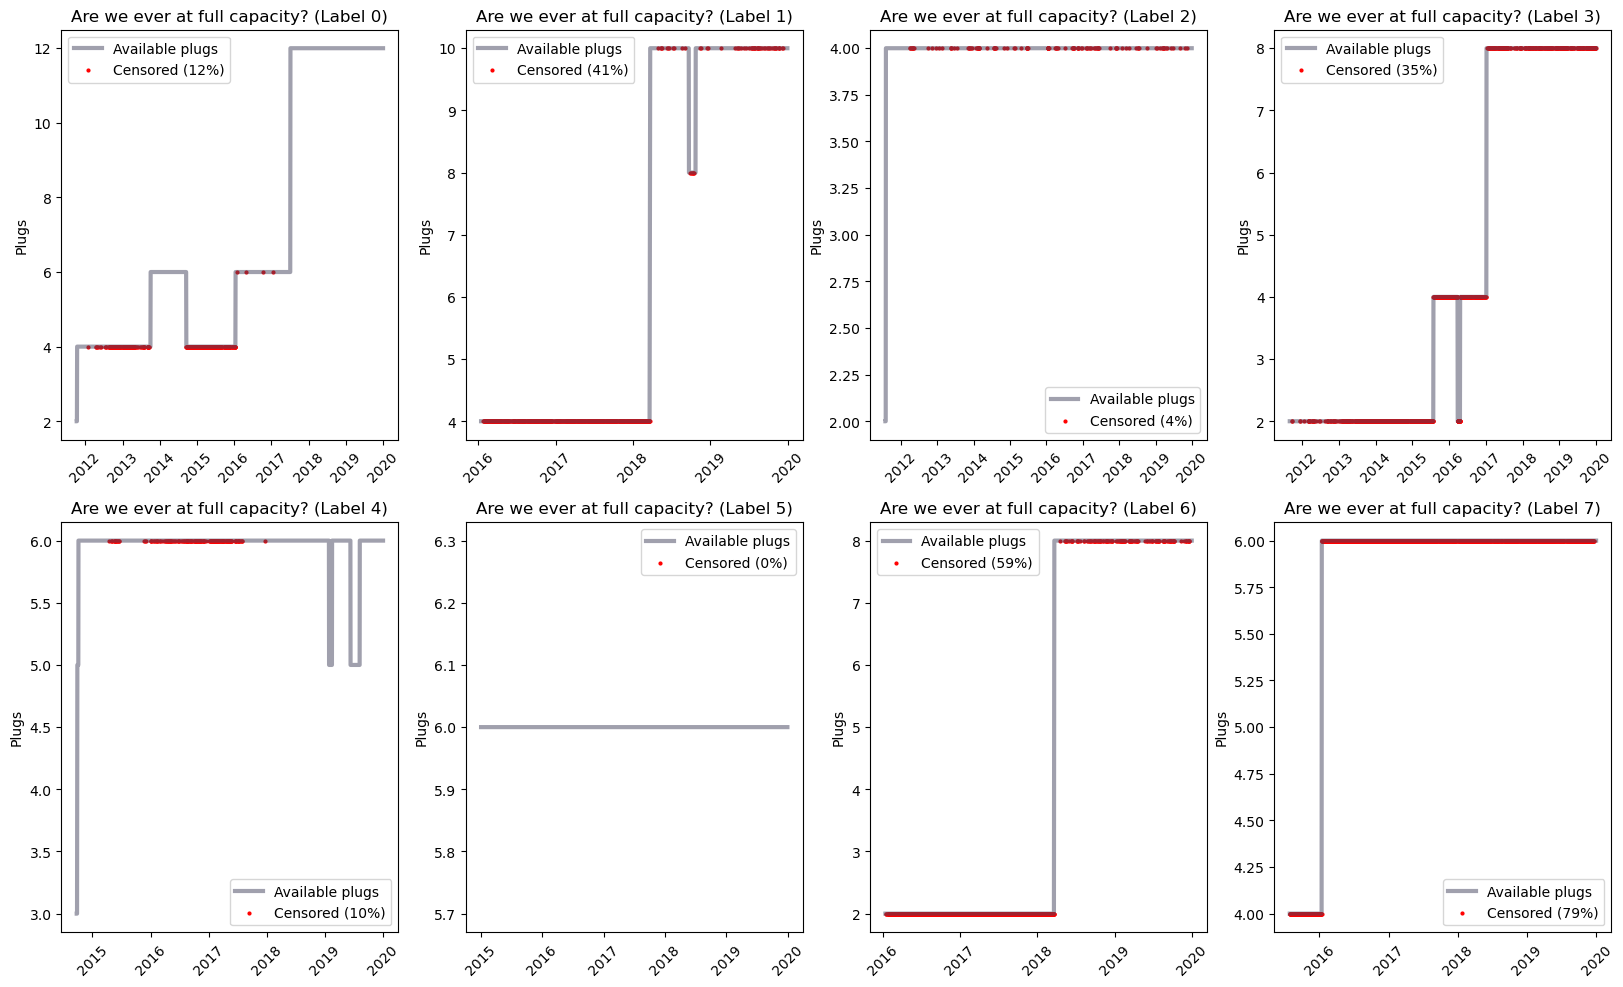

In [123]:
#for l in np.sort(df['Label'].unique()):   
fig = plt.figure(figsize=(20,25), dpi= 100)

for ix, l in enumerate(np.sort((df['Label'].unique()))):
    dfl = plugdf_with_simulatenousMax[plugdf_with_simulatenousMax['Label'] == l]
    percent_censored = 100 * (len(dfl[(dfl['Plugs'] == dfl['Simultaneous use (daily max)'])]) / len(dfl))
    percent_censored = round(percent_censored)
    
    plt.subplot(4,4,ix+1)

    plt.scatter(dfl[(dfl['Plugs'] == dfl['Simultaneous use (daily max)'])].index, dfl[(dfl['Plugs'] == dfl['Simultaneous use (daily max)'])]['Simultaneous use (daily max)'], color = 'red', alpha = 1, s = 4,  label = f"Censored ({percent_censored}%)") #
    plt.plot(dfl.index, dfl['Plugs'], color = cmap(0.3), label = 'Available plugs', lw = 3, alpha = 0.5)
    plt.ylabel('Plugs')
    plt.legend()
    plt.title(f'Are we ever at full capacity? (Label {l})')
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    
    

    #plt.subplot(4,4,ix+1)
#
    #plt.scatter(plugdf_with_simulatenousMax[(plugdf_with_simulatenousMax['Label'] == l) & (plugdf_with_simulatenousMax['Plugs'] == plugdf_with_simulatenousMax['Simultaneous use (daily max)'])].index, plugdf_with_simulatenousMax[(plugdf_with_simulatenousMax['Label'] == l) & (plugdf_with_simulatenousMax['Plugs'] == plugdf_with_simulatenousMax['Simultaneous use (daily max)'])]['Simultaneous use (daily max)'], color = 'red', alpha = 1, s = 4,  label = 'Censored') #
    #plt.plot(plugdf_with_simulatenousMax[plugdf_with_simulatenousMax['Label'] == l].index, plugdf_with_simulatenousMax[plugdf_with_simulatenousMax['Label'] == l]['Plugs'], color = cmap(0.3), label = 'Available plugs', lw = 3, alpha = 0.5)
    #plt.ylabel('Plugs')
    #plt.legend()
    #plt.title(f'Are we ever at full capacity? (Label {l})')
    #ax = plt.gca()
    #ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    #
    #plt.show()
    
    
    percent_censored = 100 * (len(dfl[(dfl['Plugs'] == dfl['Simultaneous use (daily max)'])]) / len(dfl))

    #print(f"Percent censored in label {l}: {(round(percent_censored))}%")
    #len(t[(t['Label'] == 6) & (t['Simultaneous use (daily max)'] == t['Plugs'])]) / len(t[t['Label'] == 6])
plt.show()

In [124]:
#create the filan with censoring indicator
df_final_censoredB = df_days_with_external[['Date', 'Label', 'Charging Time (mins)', 'Parking Time (mins)',
       'Energy (kWh)', 'Fee (USD)', '# Food', '# Shop & Service',
       '# Professional & Other Places', '# Nightlife Spot',
       '# Outdoors & Recreation', '# Arts & Entertainment',
       '# Travel & Transport', '# College & University', '# Event',
       '# Residence', 'Label_0', 'Label_1', 'Label_2', 'Label_3',
       'Label_4', 'Label_5', 'Label_6', 'Label_7', 'Month_Day_1',
       'Month_Day_2', 'Month_Day_3', 'Month_Day_4', 'Month_Day_5',
       'Month_Day_6', 'Month_Day_7', 'Month_Day_8', 'Month_Day_9',
       'Month_Day_10', 'Month_Day_11', 'Month_Day_12', 'Month_Day_13',
       'Month_Day_14', 'Month_Day_15', 'Month_Day_16', 'Month_Day_17',
       'Month_Day_18', 'Month_Day_19', 'Month_Day_20', 'Month_Day_21',
       'Month_Day_22', 'Month_Day_23', 'Month_Day_24', 'Month_Day_25',
       'Month_Day_26', 'Month_Day_27', 'Month_Day_28', 'Month_Day_29',
       'Month_Day_30', 'Month_Day_31', 'Week_Day_0', 'Week_Day_1',
       'Week_Day_2', 'Week_Day_3', 'Week_Day_4', 'Week_Day_5', 'Week_Day_6',
       'Year_Month_1', 'Year_Month_2', 'Year_Month_3', 'Year_Month_4',
       'Year_Month_5', 'Year_Month_6', 'Year_Month_7', 'Year_Month_8',
       'Year_Month_9', 'Year_Month_10', 'Year_Month_11', 'Year_Month_12',
       'Holiday', 'Days_previous_holiday', 'Days_next_holiday']]

In [126]:
cens_numIndex = plugdf_with_simulatenousMax.reset_index()

In [127]:
df_final_censoredB = df_final_censoredB.merge(cens_numIndex, left_on = ['Date', 'Label'], right_on=['Date', 'Label'])

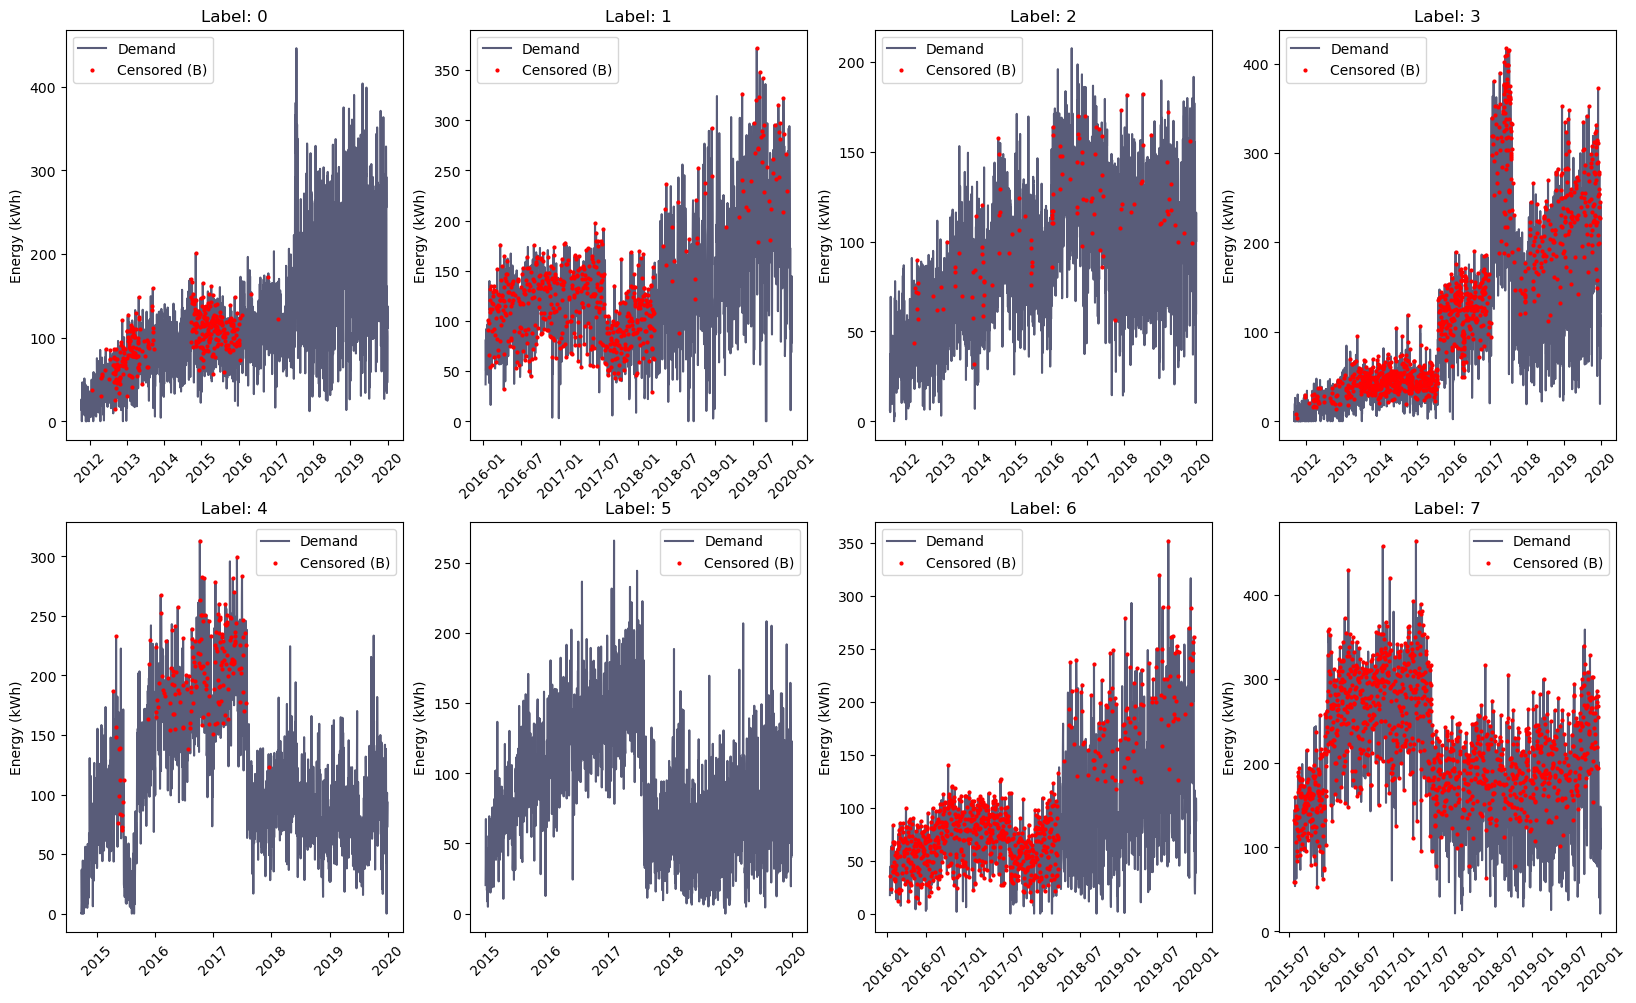

In [128]:
#plt.plot[ww[ww['Label'] == 0]['Energy (kWh)']]
#plt.show()
#la = 5
fig = plt.figure(figsize=(20,25), dpi= 100)
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


for ix, la in enumerate(np.sort((df_final_censoredB['Label'].unique()))):
    dfla = df_final_censoredB[df_final_censoredB['Label'] == la]
    dftemp = dfla[(dfla['Energy (kWh)'] != 0).cumsum() > 0]
    
    #dftemp.index = pd.to_datetime(dftemp.index)
    
    #fig, ax = plt.subplots()
    plt.subplot(4,4,ix+1)
    #xaxis.set_major_locator(matplotlib.dates.YearLocator())
    plt.plot(dftemp['Date'], dftemp['Energy (kWh)'], zorder=0, color = cmap(0.4), label = 'Demand')
    plt.scatter(dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Date'], dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Energy (kWh)'], color = 'red', alpha = 1, s = 4,  label = 'Censored (B)') #

    plt.xticks(rotation=45)
    plt.ylabel('Energy (kWh)')
    plt.legend()
    


    plt.title(f"Label: {la}")

plt.show()
#fig.savefig('TheTargetVariable.png')

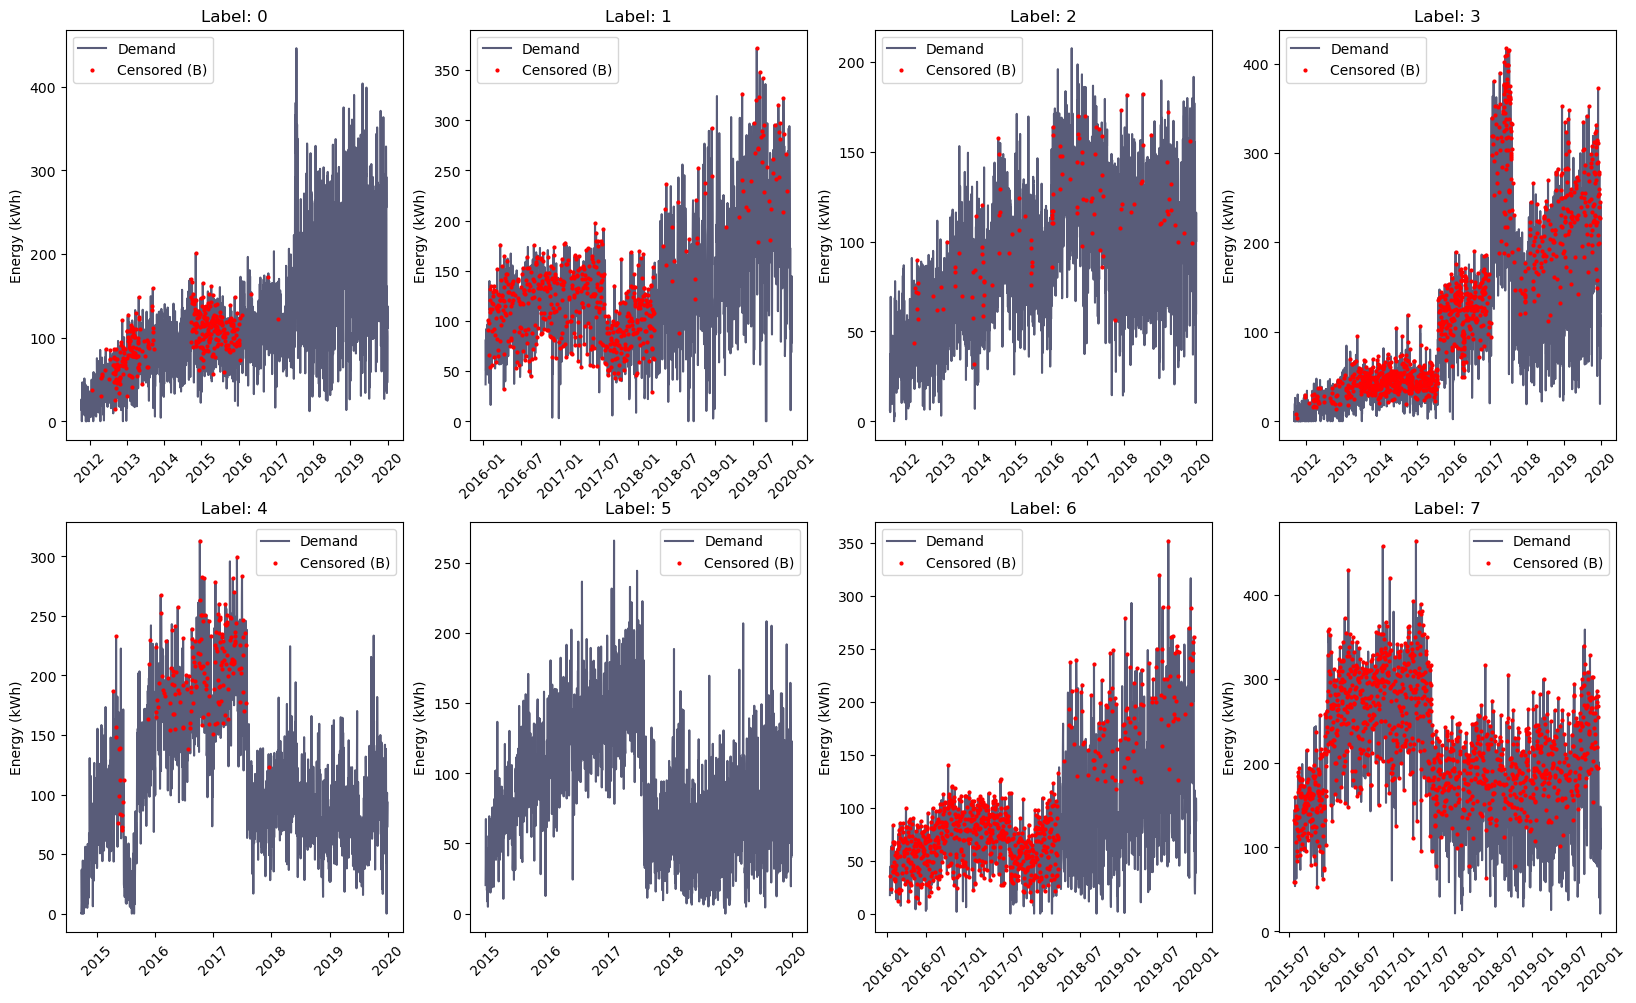

In [129]:
#plt.plot[ww[ww['Label'] == 0]['Energy (kWh)']]
#plt.show()
#la = 5
fig = plt.figure(figsize=(20,25), dpi= 100)
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


for ix, la in enumerate(np.sort((df_final_censoredB['Label'].unique()))):
    dfla = df_final_censoredB[df_final_censoredB['Label'] == la]
    dftemp = dfla[(dfla['Energy (kWh)'] != 0).cumsum() > 0]
    
    #dftemp.index = pd.to_datetime(dftemp.index)
    
    #fig, ax = plt.subplots()
    plt.subplot(4,4,ix+1)
    #xaxis.set_major_locator(matplotlib.dates.YearLocator())
    plt.plot(dftemp['Date'], dftemp['Energy (kWh)'], zorder=0, color = cmap(0.4), label = 'Demand')
    plt.scatter(dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Date'], dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Energy (kWh)'], color = 'red', alpha = 1, s = 4,  label = 'Censored (B)') #

    plt.xticks(rotation=45)
    plt.ylabel('Energy (kWh)')
    plt.legend()
    


    plt.title(f"Label: {la}")

plt.show()
#fig.savefig('TheTargetVariable.png')

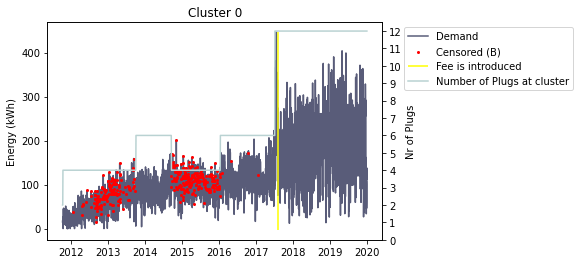

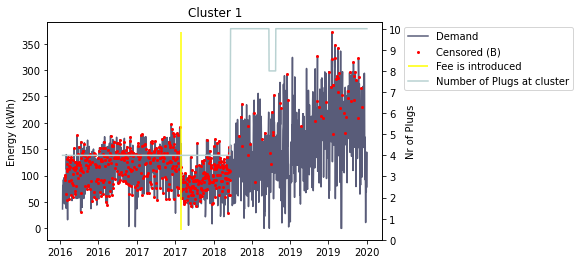

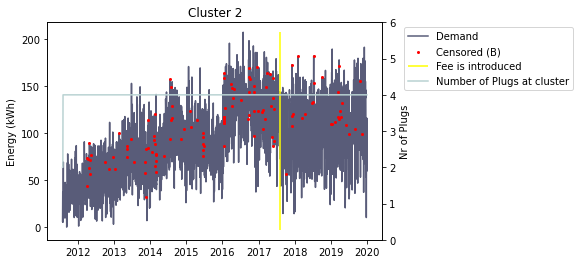

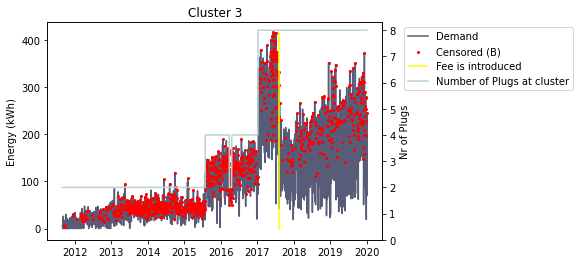

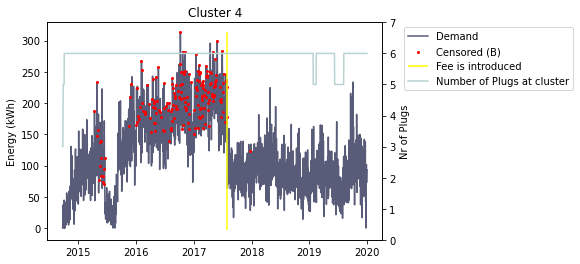

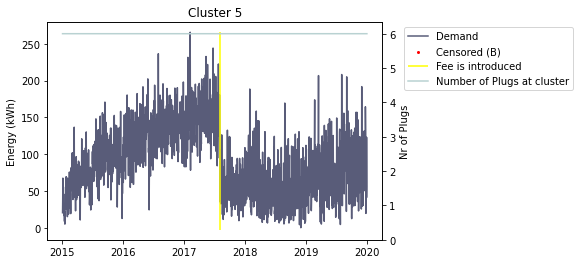

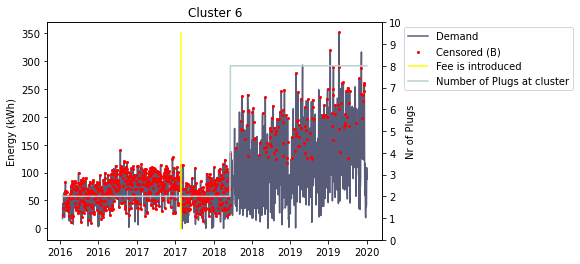

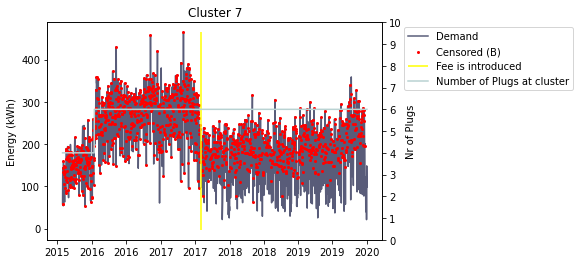

In [130]:
#plt.plot[ww[ww['Label'] == 0]['Energy (kWh)']]
#plt.show()
#la = 5

#for ix, la in enumerate(np.sort((df_final_censoredB['Label'].unique()))):

for la in range(len(df_final_censoredB['Label'].unique())):
    dfla = df_final_censoredB[df_final_censoredB['Label'] == la]
    dftemp = dfla[(dfla['Energy (kWh)'] != 0).cumsum() > 0]
    #dftemp.index = pd.to_datetime(dftemp.index)
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.plot(dftemp['Date'], dftemp['Energy (kWh)'], zorder=0, color = cmap(0.4), label = 'Demand')
    ax.scatter(dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Date'], dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Energy (kWh)'], color = 'red', alpha = 1, s = 4,  label = 'Censored (B)') #

    
    ax.set_ylabel('Energy (kWh)')
    ax.vlines(dftemp[dftemp['Fee (USD)'] != 0]['Date'].min(), ymin = -3, ymax = dftemp['Energy (kWh)'].max(), color = 'yellow', label="Fee is introduced")

    handlesax, labelsax = ax.get_legend_handles_labels()

    
    ax2 = ax.twinx() 
    #ax2.plot(dftemp.index, dftemp['Plugs'])
    ax2.plot(dftemp['Date'], dftemp['Plugs'], color = cmap(0.8), label = 'Number of Plugs at cluster')

    #ax2.plot(dftemp.index, dftemp['Number of NEMA 5-20R'], color = 'yellow')

    ax2.set_ylabel('Nr of Plugs')
    yint = range(0, math.ceil(max(dftemp['Plugs_raw']))+1) #math.floor(min(dftemp['Plugs']))
    ax2.set_yticks(yint)
    
    ax2.title.set_text(f"Cluster {la}")
    handlesax2, labelsax2 = ax2.get_legend_handles_labels()

    #ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    #((ww[ww['Label'] == la]['Energy (kWh)'] - ww[ww['Label'] == la]['Energy (kWh)'].mean())/ ww[ww['Label'] == la]['Energy (kWh)'].std()).plot(label = "Standardized consumption")
    #(ww[ww['Label'] == la]['Plugs']).plot(label = "Nr of plugs")
    #plt.vlines(ww[ww['Fee (USD)'] != 0].index.min(), ymin = -3, ymax = ww[ww['Label'] == la]['Plugs'].max(), color = 'red', label="Fee is introduced")
    #plt.title(f"Label: {la}")
    #plt.legend()
    handles = handlesax + handlesax2
    labels = labelsax + labelsax2
    
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [12]:
df_final_censoredB

,Unnamed: 0,Date,Label,Charging Time (mins),Parking Time (mins),Energy (kWh),Fee (USD),# Food,# Shop & Service,# Professional & Other Places,...,Year_Month_11,Year_Month_12,Holiday,Days_previous_holiday,Days_next_holiday,Plugs_raw,Number of NEMA 5-20R_raw,Plugs,Number of NEMA 5-20R,Simultaneous use (daily max)
0,0,2011-07-29,2,114.050000,183.533333,6.249457,0.000000,127.0,99.0,86,...,0,0,0,25,38,2.0,1.0,2.0,1.0,1.0
1,1,2011-07-30,2,517.200000,686.650000,28.978653,0.000000,127.0,99.0,86,...,0,0,0,26,37,2.0,1.0,2.0,1.0,1.0
2,2,2011-07-31,2,647.866667,725.983333,37.209163,0.000000,127.0,99.0,86,...,0,0,0,27,36,2.0,1.0,2.0,1.0,1.0
3,3,2011-08-01,2,95.133333,203.566667,5.041244,0.000000,127.0,99.0,86,...,0,0,0,28,35,2.0,1.0,2.0,1.0,1.0
4,4,2011-08-02,2,279.983333,280.316667,16.210423,0.000000,127.0,99.0,86,...,0,0,0,29,34,4.0,2.0,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17384,17384,2019-12-27,0,1320.766667,1501.966667,100.728000,24.500000,132.0,105.0,83,...,0,1,0,2,5,12.0,3.0,12.0,3.0,5.0
17385,17385,2019-12-28,0,545.383333,620.633333,46.182000,11.000000,132.0,105.0,83,...,0,1,0,3,4,12.0,3.0,12.0,3.0,3.0
17386,17386,2019-12-29,0,755.300000,971.516667,61.271000,15.090000,132.0,105.0,83,...,0,1,0,4,3,12.0,3.0,12.0,3.0,3.0
17387,17387,2019-12-30,0,1766.329655,1999.293908,137.772290,31.688414,132.0,105.0,83,...,0,1,0,5,2,12.0,3.0,12.0,3.0,5.0


In [131]:
#df_final_censoredB.to_csv('df_days_with_external_censoredB_27052021.csv')

### Only plots

In [5]:
df_final_censoredB = pd.read_csv('df_days_with_external_censoredB_27052021.csv')
df_final_censoredB['Date'] = pd.to_datetime(df_final_censoredB['Date'])

FileNotFoundError: [Errno 2] No such file or directory: 'df_days_with_external_censoredB_27052021.csv'

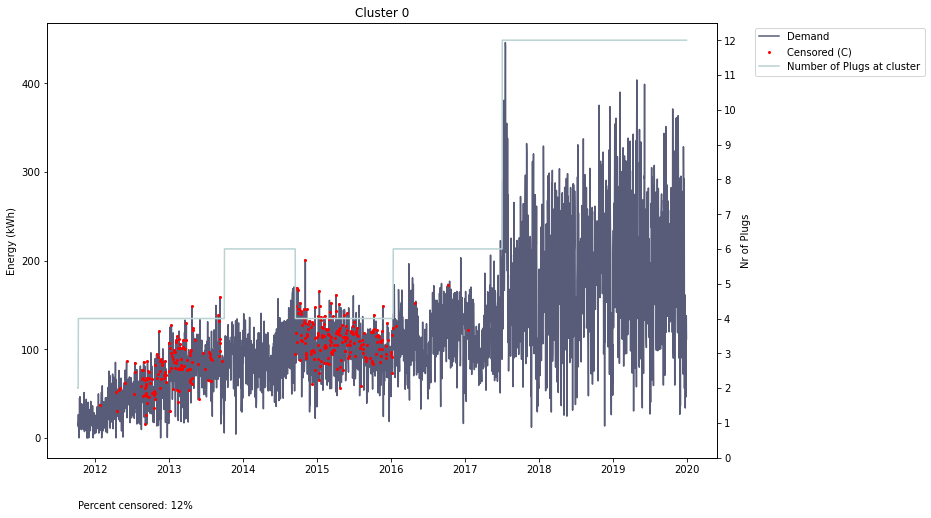

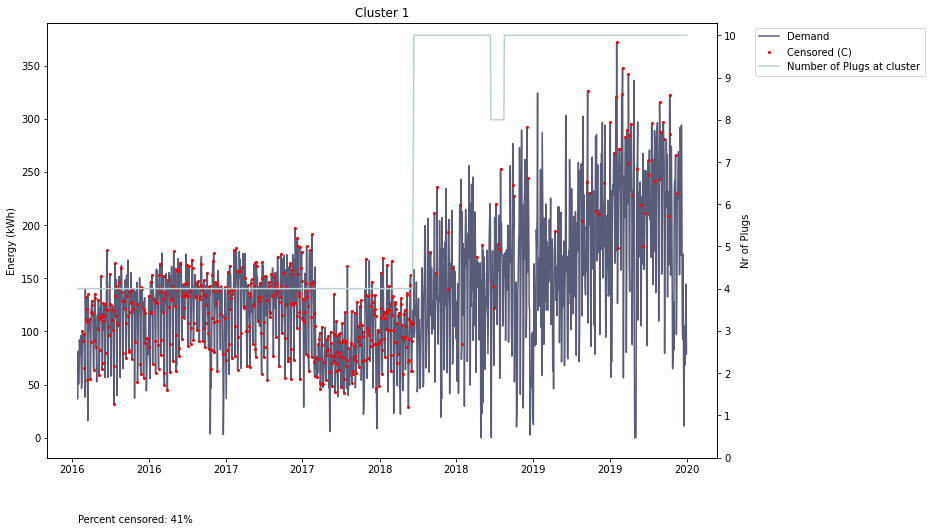

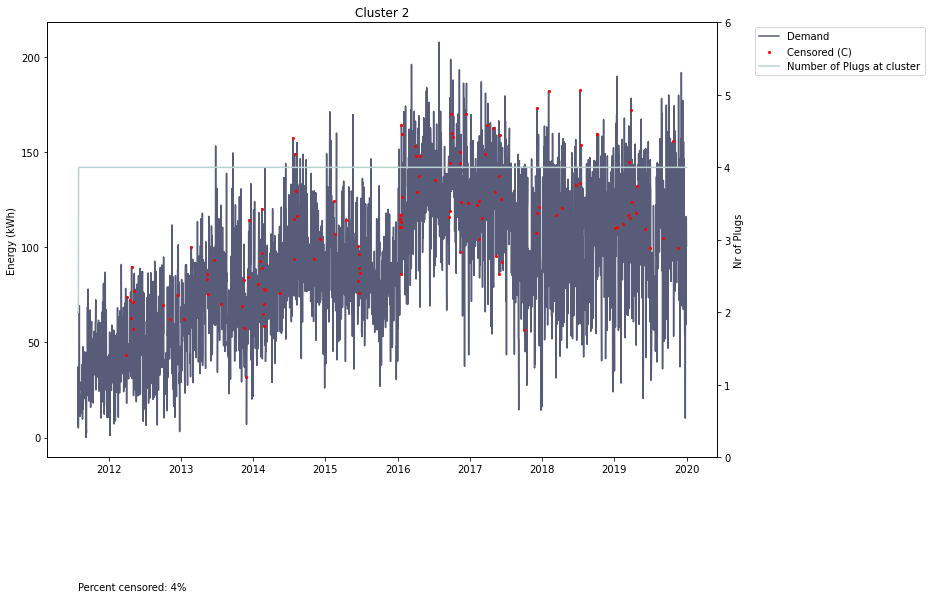

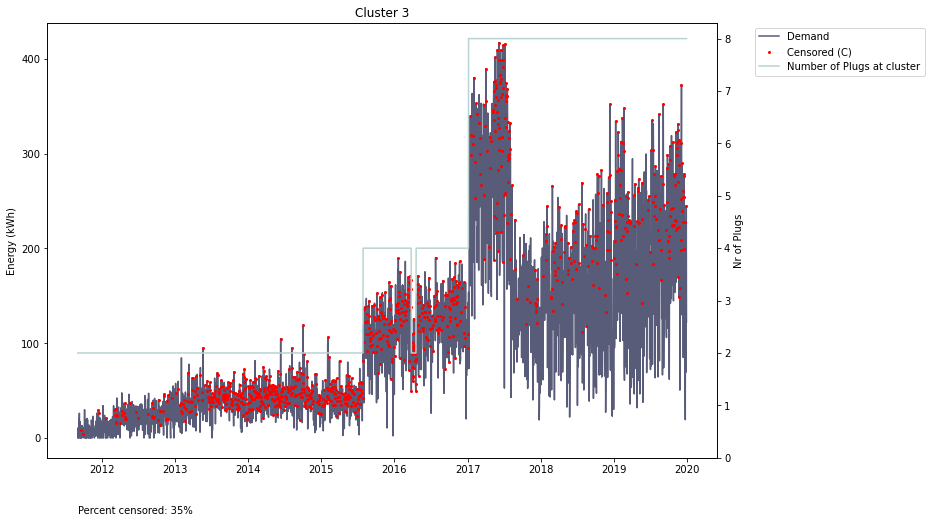

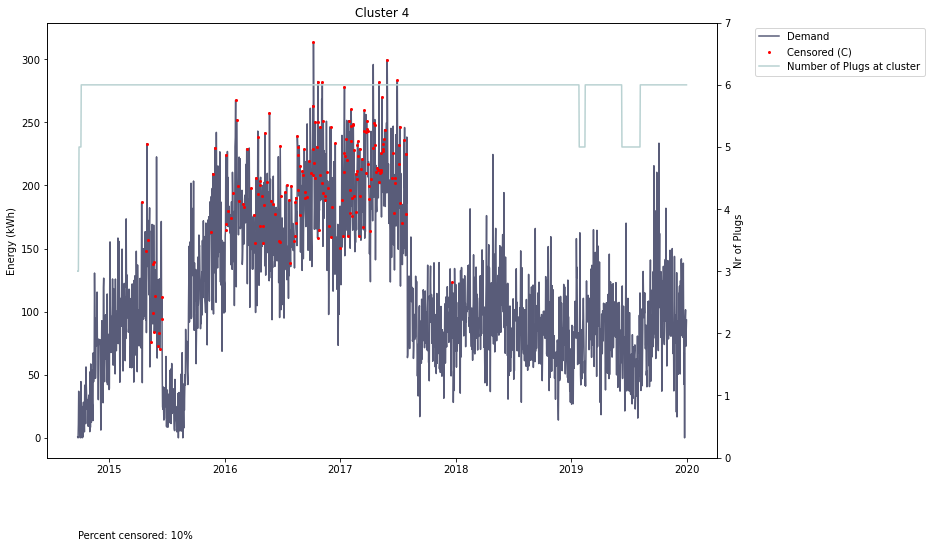

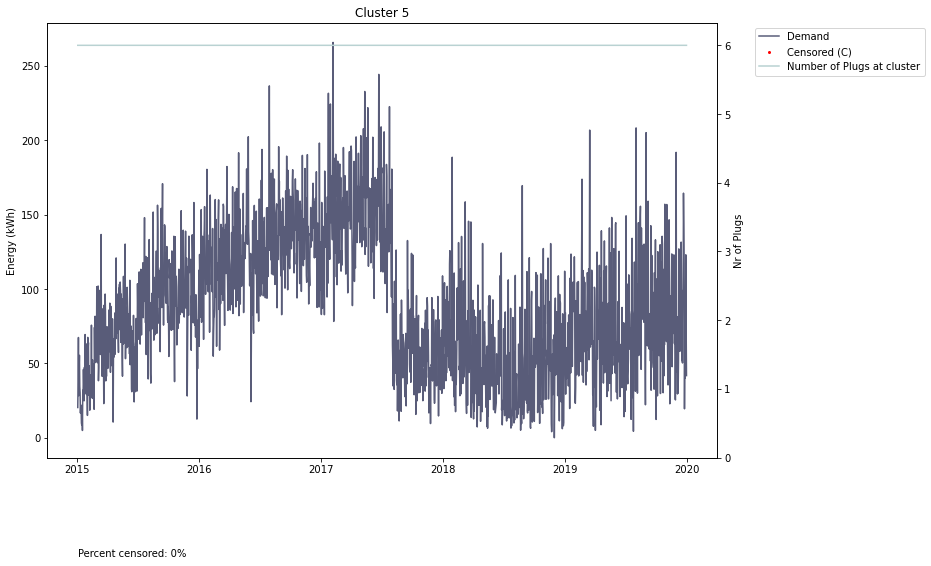

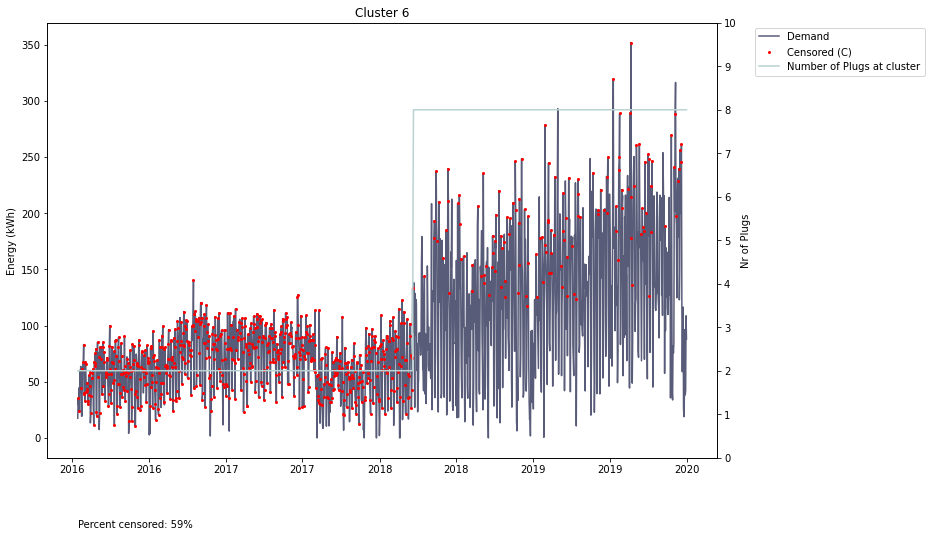

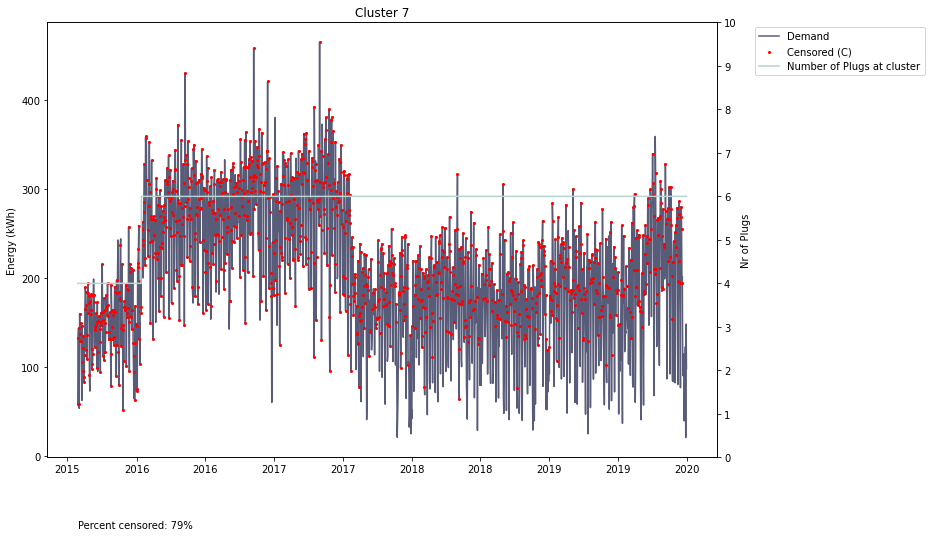

In [45]:
#plt.plot[ww[ww['Label'] == 0]['Energy (kWh)']]
#plt.show()
#la = 5

#for ix, la in enumerate(np.sort((df_final_censoredB['Label'].unique()))):

for la in range(len(df_final_censoredB['Label'].unique())):
    dftemp = df_final_censoredB[df_final_censoredB['Label'] == la]
    #dftemp = dfla[(dfla['Energy (kWh)'] != 0).cumsum() > 0]

    percent_censored = round(100 * (len(dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]) / len(dftemp)))
    textx = dftemp['Date'].min()
    
    fig, ax = plt.subplots(figsize = (12,8))
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.plot(dftemp['Date'], dftemp['Energy (kWh)'], zorder=0, color = cmap(0.4), label = 'Demand')
    ax.scatter(dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Date'], dftemp[(dftemp['Plugs'] == dftemp['Simultaneous use (daily max)'])]['Energy (kWh)'], color = 'red', alpha = 1, s = 4,  label = 'Censored (C)') #

    
    ax.set_ylabel('Energy (kWh)')
    #ax.vlines(dftemp[dftemp['Fee (USD)'] != 0]['Date'].min(), ymin = -3, ymax = dftemp['Energy (kWh)'].max(), color = 'yellow', label="Fee is introduced")

    handlesax, labelsax = ax.get_legend_handles_labels()

    
    ax2 = ax.twinx() 
    #ax2.plot(dftemp.index, dftemp['Plugs'])
    ax2.plot(dftemp['Date'], dftemp['Plugs'], color = cmap(0.8), label = 'Number of Plugs at cluster')

    #ax2.plot(dftemp.index, dftemp['Number of NEMA 5-20R'], color = 'yellow')

    ax2.set_ylabel('Nr of Plugs')
    yint = range(0, math.ceil(max(dftemp['Plugs_raw']))+1) #math.floor(min(dftemp['Plugs']))
    ax2.set_yticks(yint)
    
    ax2.title.set_text(f"Cluster {la}")
    handlesax2, labelsax2 = ax2.get_legend_handles_labels()

    #ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    #((ww[ww['Label'] == la]['Energy (kWh)'] - ww[ww['Label'] == la]['Energy (kWh)'].mean())/ ww[ww['Label'] == la]['Energy (kWh)'].std()).plot(label = "Standardized consumption")
    #(ww[ww['Label'] == la]['Plugs']).plot(label = "Nr of plugs")
    #plt.vlines(ww[ww['Fee (USD)'] != 0].index.min(), ymin = -3, ymax = ww[ww['Label'] == la]['Plugs'].max(), color = 'red', label="Fee is introduced")
    #plt.title(f"Label: {la}")
    #plt.legend()
    handles = handlesax + handlesax2
    labels = labelsax + labelsax2
    
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.text(textx, -80, f"Percent censored: {percent_censored}%")
    plt.show()


### B

In [24]:
df_final_censoredBB = pd.read_csv('df_censoredB.csv')
df_final_censoredBB = df_final_censoredBB.rename(columns = {'Start Date': 'Date'})
df_final_censoredBB['Date'] = pd.to_datetime(df_final_censoredB['Date'])


In [25]:
df_final_censoredBB

,Date,Label,Charging Time (mins),Parking Time (mins),Energy (kWh)_x,Fee (USD)_x,# Food,# Shop & Service,# Professional & Other Places,# Nightlife Spot,...,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,Holiday,Days_previous_holiday,Days_next_holiday,Energy (kWh)_y,Fee (USD)_y,Censored
0,2011-07-29,2,114.050000,183.533333,6.249457,0.000000,127.0,99.0,86,87.0,...,0,0,0,0,0,25,38,6.249457,0.000000,False
1,2011-07-30,2,517.200000,686.650000,28.978653,0.000000,127.0,99.0,86,87.0,...,0,0,0,0,0,26,37,28.978653,0.000000,False
2,2011-07-31,2,647.866667,725.983333,37.209163,0.000000,127.0,99.0,86,87.0,...,0,0,0,0,0,27,36,37.209163,0.000000,False
3,2011-08-01,2,95.133333,203.566667,5.041244,0.000000,127.0,99.0,86,87.0,...,0,0,0,0,0,28,35,5.041244,0.000000,False
4,2011-08-02,2,279.983333,280.316667,16.210423,0.000000,127.0,99.0,86,87.0,...,0,0,0,0,0,29,34,4.197217,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17384,2019-12-27,0,1320.766667,1501.966667,100.728000,24.500000,132.0,105.0,83,69.0,...,0,0,0,1,0,2,5,49.500000,11.380000,True
17385,2019-12-28,0,545.383333,620.633333,46.182000,11.000000,132.0,105.0,83,69.0,...,0,0,0,1,0,3,4,0.034000,0.000000,True
17386,2019-12-29,0,755.300000,971.516667,61.271000,15.090000,132.0,105.0,83,69.0,...,0,0,0,1,0,4,3,29.411000,6.760000,True
17387,2019-12-30,0,1766.329655,1999.293908,137.772290,31.688414,132.0,105.0,83,69.0,...,0,0,0,1,0,5,2,33.961290,7.808414,True


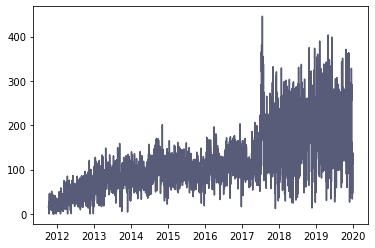

In [27]:
dftemp = df_final_censoredBB[df_final_censoredBB['Label'] == 0]
plt.plot(dftemp['Date'], dftemp['Energy (kWh)_x'], zorder=0, color = cmap(0.4), label = 'Demand')

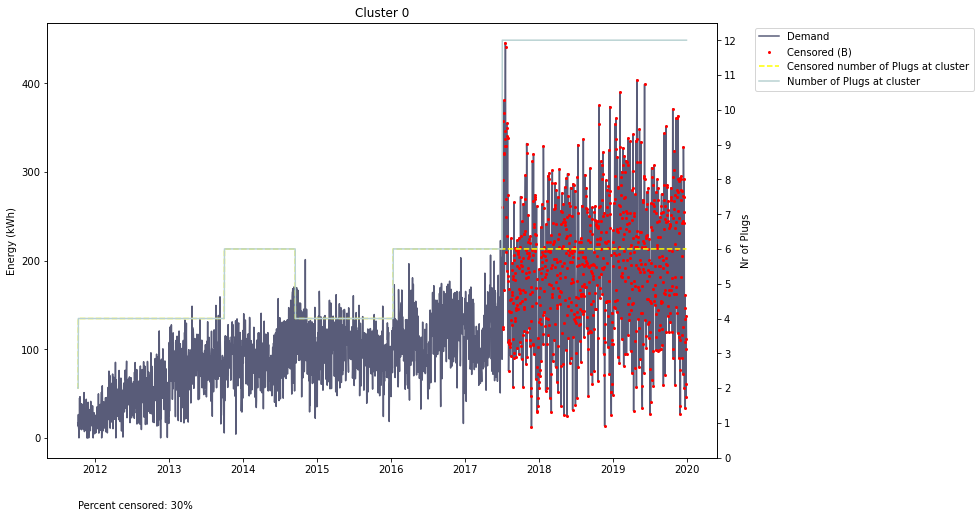

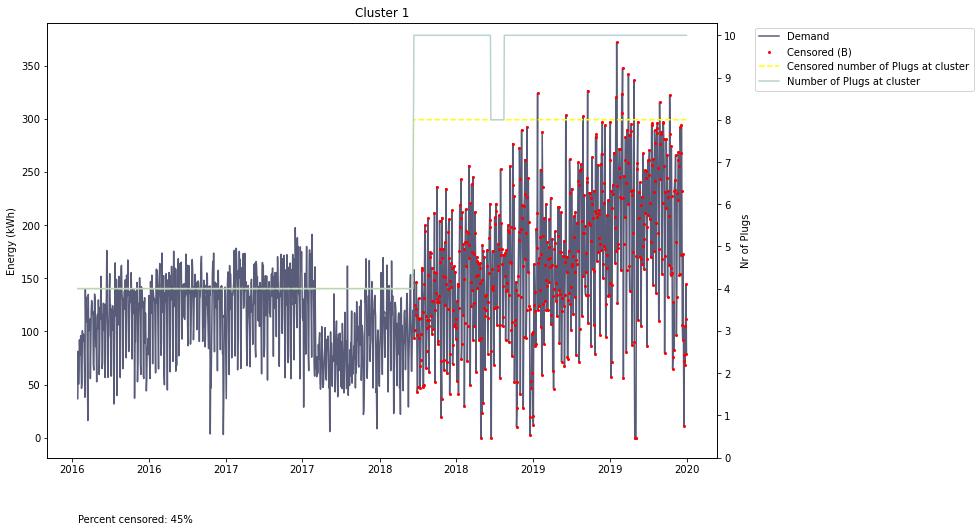

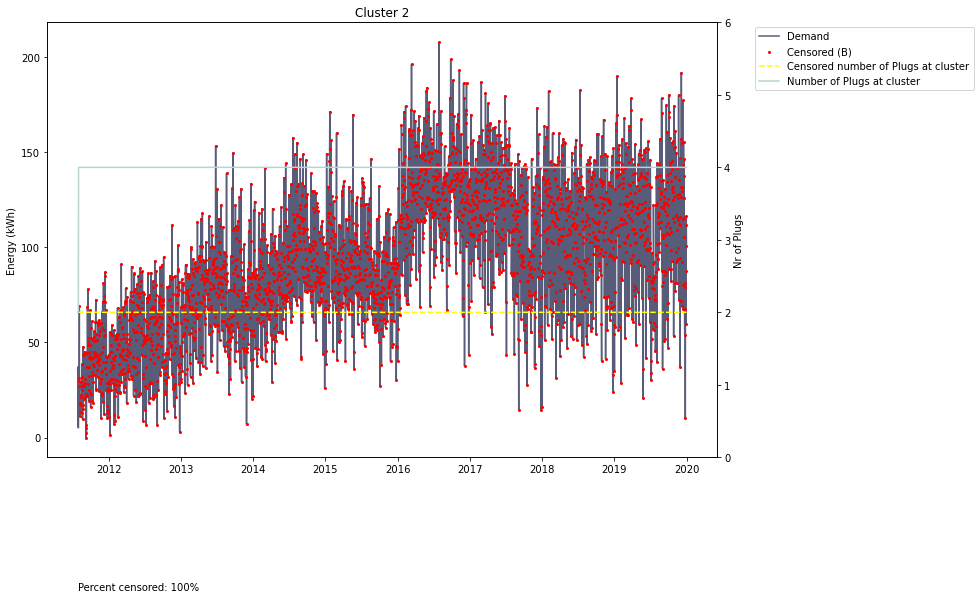

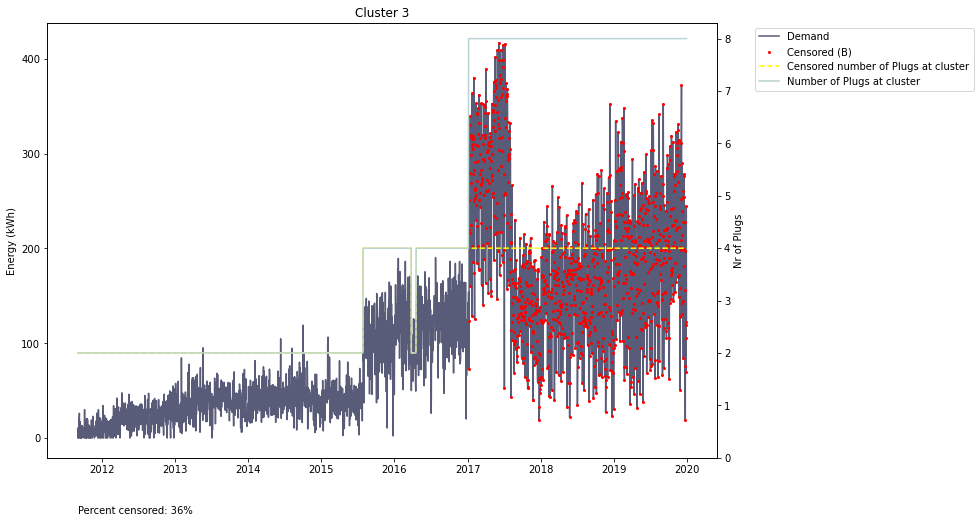

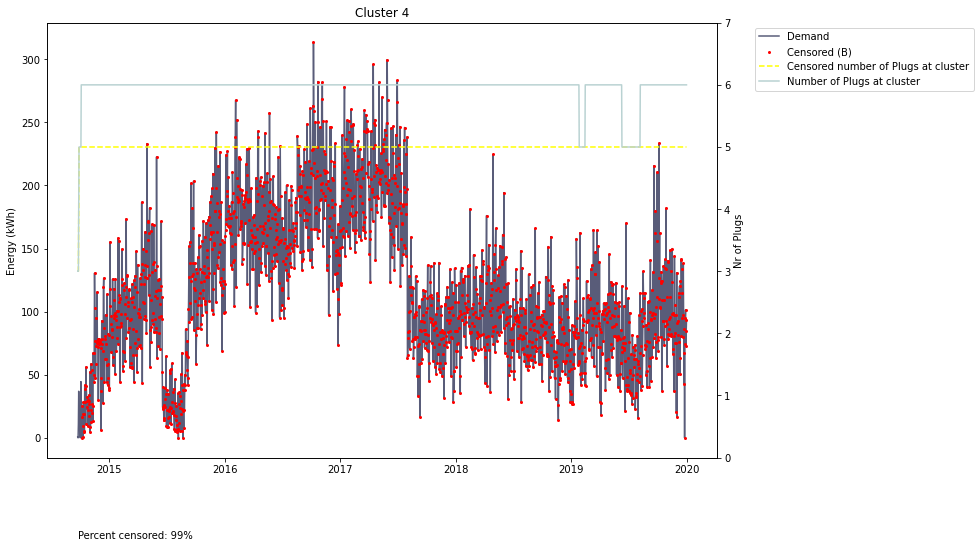

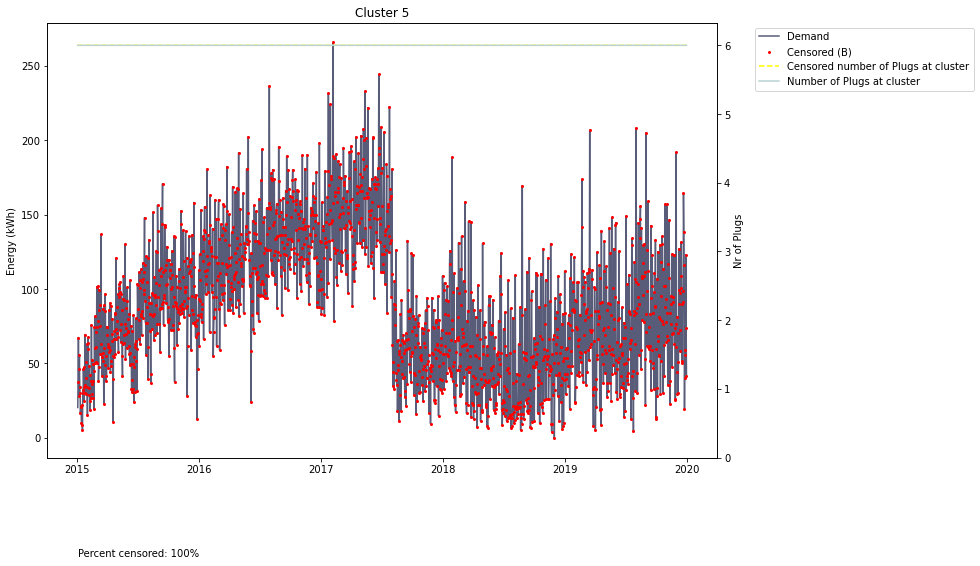

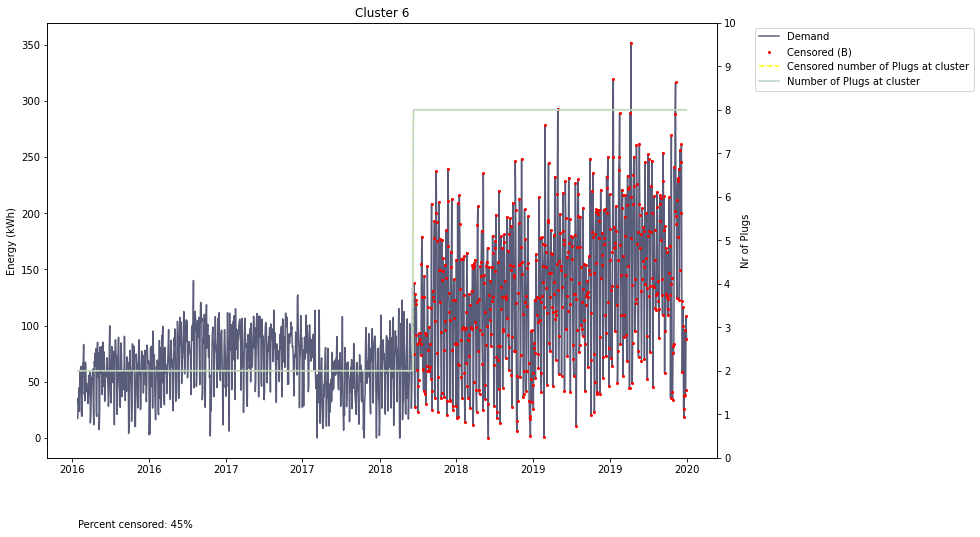

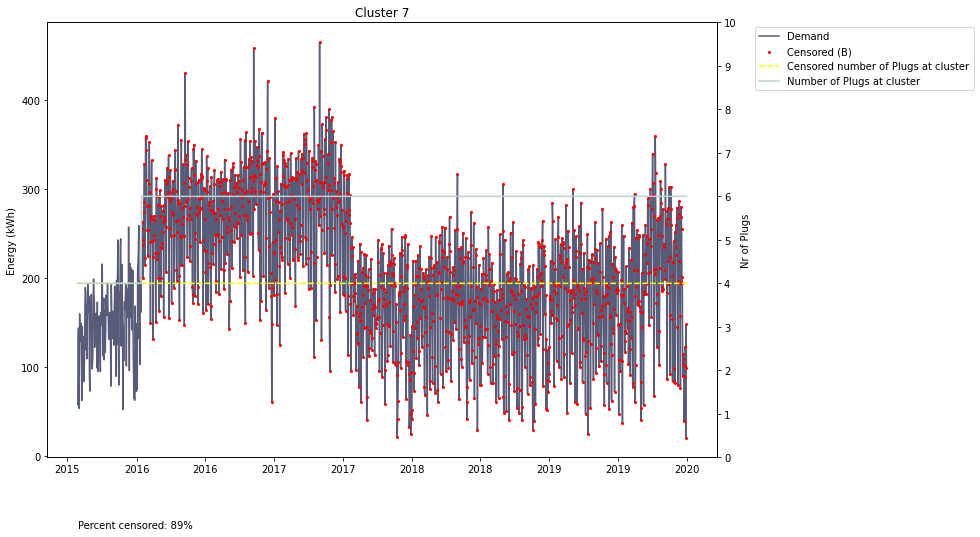

In [47]:
#plt.plot[ww[ww['Label'] == 0]['Energy (kWh)']]
#plt.show()
#la = 5

#for ix, la in enumerate(np.sort((df_final_censoredB['Label'].unique()))):

for la in range(len(df_final_censoredBB['Label'].unique())):
    dftemp = df_final_censoredBB[df_final_censoredBB['Label'] == la]
    dftempTruePlugs = df_final_censoredB[df_final_censoredBB['Label'] == la]
    #dftemp = dfla[(dfla['Energy (kWh)'] != 0).cumsum() > 0]

    percent_censored = round(100 * (len(dftemp[(dftemp['Censored'] == True)])) / len(dftemp))
    textx = dftemp['Date'].min()

    
    fig, ax = plt.subplots(figsize = (12,8))
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.plot(dftemp['Date'], dftemp['Energy (kWh)_x'], zorder=0, color = cmap(0.4), label = 'Demand')
    ax.scatter(dftemp[(dftemp['Censored'] == True)]['Date'], dftemp[(dftemp['Censored'] == True)]['Energy (kWh)_x'], color = 'red', alpha = 1, s = 4,  label = 'Censored (B)') #

    
    ax.set_ylabel('Energy (kWh)')
    #ax.vlines(dftemp[dftemp['Fee (USD)_x'] != 0]['Date'].min(), ymin = -3, ymax = dftemp['Energy (kWh)_x'].max(), color = 'yellow', label="Fee is introduced")

    handlesax, labelsax = ax.get_legend_handles_labels()

    
    ax2 = ax.twinx() 
    #ax2.plot(dftemp.index, dftemp['Plugs'])
    ax2.plot(dftemp['Date'], dftemp['Plugs'], '--', color = 'yellow', label = 'Censored number of Plugs at cluster')
    ax2.plot(dftempTruePlugs['Date'], dftempTruePlugs['Plugs'], color = cmap(0.8), label = 'Number of Plugs at cluster')

    
    #ax2.plot(dftemp.index, dftemp['Number of NEMA 5-20R'], color = 'yellow')

    ax2.set_ylabel('Nr of Plugs')
    yint = range(0, math.ceil(max(dftemp['Plugs_raw']))+1) #math.floor(min(dftemp['Plugs']))
    ax2.set_yticks(yint)
    
    ax2.title.set_text(f"Cluster {la}")
    handlesax2, labelsax2 = ax2.get_legend_handles_labels()

    #ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    #((ww[ww['Label'] == la]['Energy (kWh)'] - ww[ww['Label'] == la]['Energy (kWh)'].mean())/ ww[ww['Label'] == la]['Energy (kWh)'].std()).plot(label = "Standardized consumption")
    #(ww[ww['Label'] == la]['Plugs']).plot(label = "Nr of plugs")
    #plt.vlines(ww[ww['Fee (USD)'] != 0].index.min(), ymin = -3, ymax = ww[ww['Label'] == la]['Plugs'].max(), color = 'red', label="Fee is introduced")
    #plt.title(f"Label: {la}")
    #plt.legend()
    handles = handlesax + handlesax2
    labels = labelsax + labelsax2
    
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.text(textx, -80, f"Percent censored: {percent_censored}%")

    plt.show()


## A 

In [78]:
scaler_eng = StandardScaler()

In [79]:
def censor(s):
    energy = s["Energy (kWh)_standardized"] 
    #energy_lag1 = s["Energy (kWh)_lag1"]
    #energy_lag2 = s["Energy (kWh)_lag2"]
    #energy_lag3 = s["Energy (kWh)_lag3"]
    #energy_lag4 = s["Energy (kWh)_lag4"]
    #energy_lag5 = s["Energy (kWh)_lag5"]

    s["Censored"] = False
    if energy > 0.5:
        s["Energy (kWh)_standardized"] = 0.5
        s["Censored"] = True
    #if energy_lag1 > 0.5:
    #    s["Energy (kWh)_lag1"] = 0.5
    #if energy_lag2 > 0.5:
    #    s["Energy (kWh)_lag2"] = 0.5
    #if energy_lag3 > 0.5:
    #    s["Energy (kWh)_lag3"] = 0.5
    #if energy_lag4 > 0.5:
    #    s["Energy (kWh)_lag4"] = 0.5
    #if energy_lag5 > 0.5:
    #    s["Energy (kWh)_lag5"] = 0.5
    #
    return s

In [80]:
df_final_censoredA = df_final_censoredB.copy()
df_final_censoredA['Energy (kWh)_standardized'] = df_final_censoredA["Energy (kWh)"]

In [81]:
df_final_censoredA["Energy (kWh)_standardized"] = scaler_eng.fit_transform(np.array(df_final_censoredA["Energy (kWh)_standardized"]).reshape(-1,1))

In [82]:
df_final_censoredA = df_final_censoredA.apply(censor, axis=1)

In [83]:
df_final_censoredA

,Unnamed: 0,Date,Label,Charging Time (mins),Parking Time (mins),Energy (kWh),Fee (USD),# Food,# Shop & Service,# Professional & Other Places,...,Holiday,Days_previous_holiday,Days_next_holiday,Plugs_raw,Number of NEMA 5-20R_raw,Plugs,Number of NEMA 5-20R,Simultaneous use (daily max),Energy (kWh)_standardized,Censored
0,0,2011-07-29,2,114.050000,183.533333,6.249457,0.000000,127.0,99.0,86,...,0,25,38,2.0,1.0,2.0,1.0,1.0,-1.514616,False
1,1,2011-07-30,2,517.200000,686.650000,28.978653,0.000000,127.0,99.0,86,...,0,26,37,2.0,1.0,2.0,1.0,1.0,-1.201217,False
2,2,2011-07-31,2,647.866667,725.983333,37.209163,0.000000,127.0,99.0,86,...,0,27,36,2.0,1.0,2.0,1.0,1.0,-1.087731,False
3,3,2011-08-01,2,95.133333,203.566667,5.041244,0.000000,127.0,99.0,86,...,0,28,35,2.0,1.0,2.0,1.0,1.0,-1.531275,False
4,4,2011-08-02,2,279.983333,280.316667,16.210423,0.000000,127.0,99.0,86,...,0,29,34,4.0,2.0,4.0,2.0,1.0,-1.377270,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17384,17384,2019-12-27,0,1320.766667,1501.966667,100.728000,24.500000,132.0,105.0,83,...,0,2,5,12.0,3.0,12.0,3.0,5.0,-0.211908,False
17385,17385,2019-12-28,0,545.383333,620.633333,46.182000,11.000000,132.0,105.0,83,...,0,3,4,12.0,3.0,12.0,3.0,3.0,-0.964010,False
17386,17386,2019-12-29,0,755.300000,971.516667,61.271000,15.090000,132.0,105.0,83,...,0,4,3,12.0,3.0,12.0,3.0,3.0,-0.755957,False
17387,17387,2019-12-30,0,1766.329655,1999.293908,137.772290,31.688414,132.0,105.0,83,...,0,5,2,12.0,3.0,12.0,3.0,5.0,0.298873,False


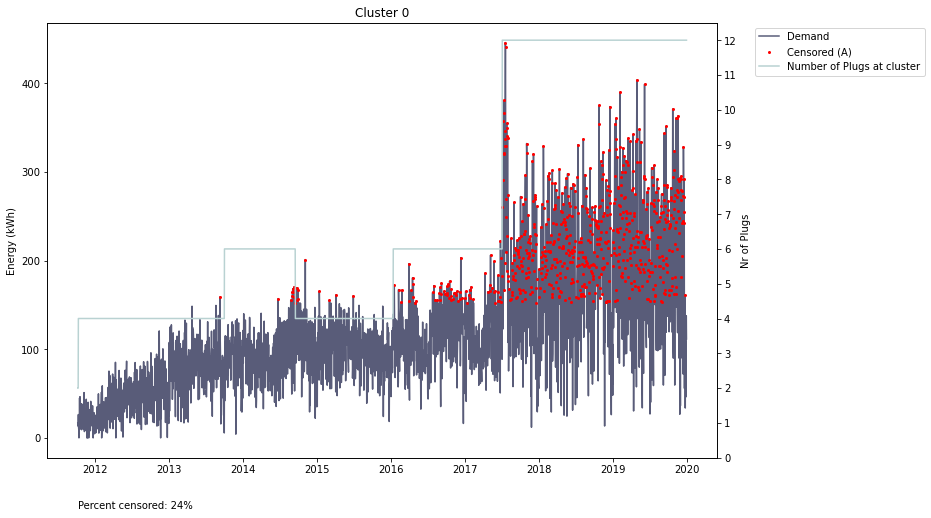

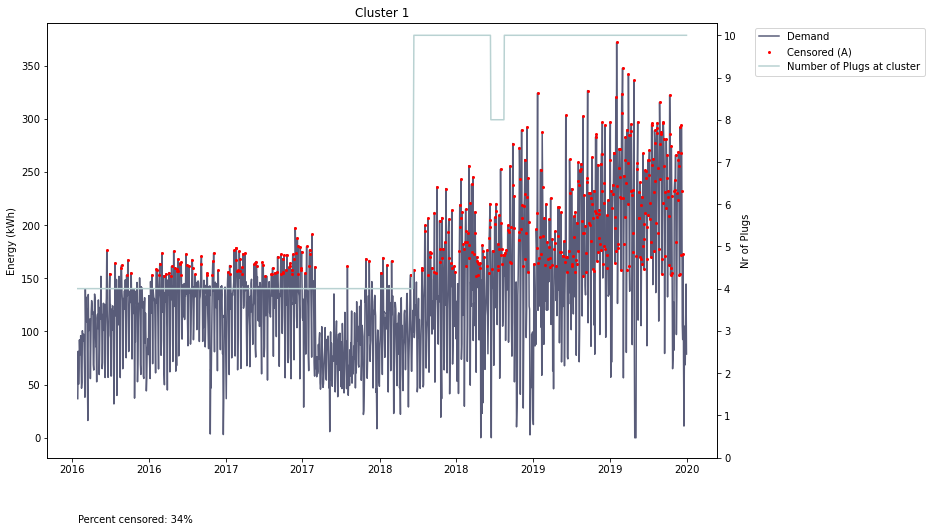

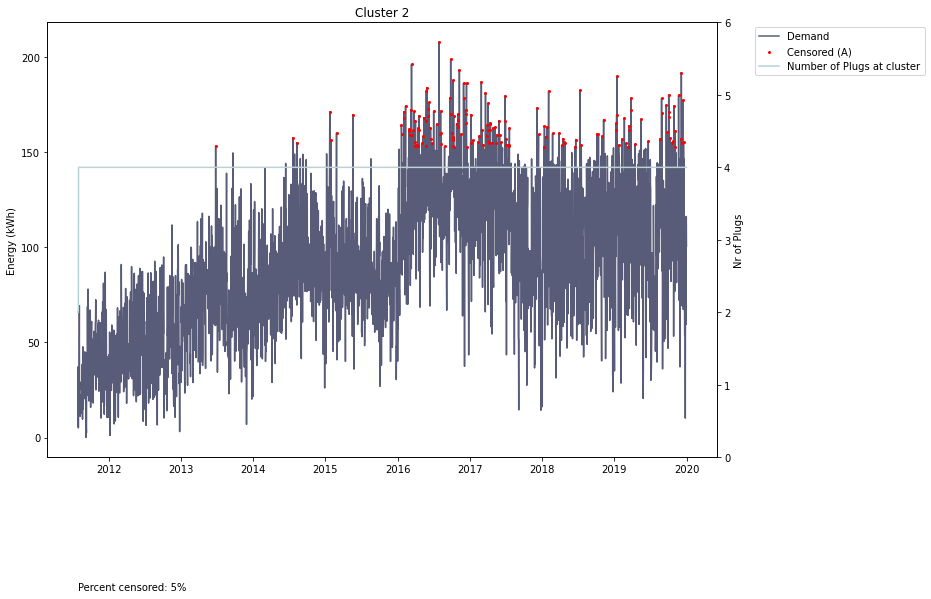

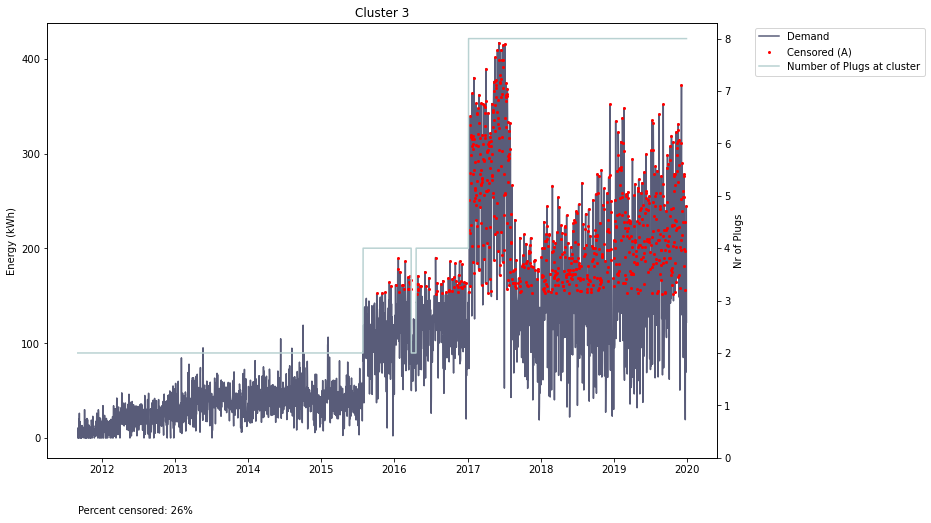

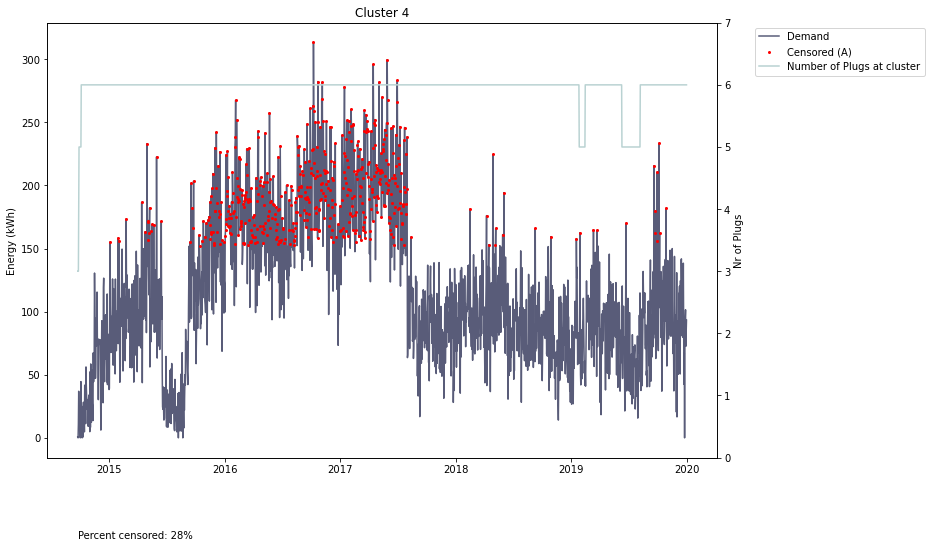

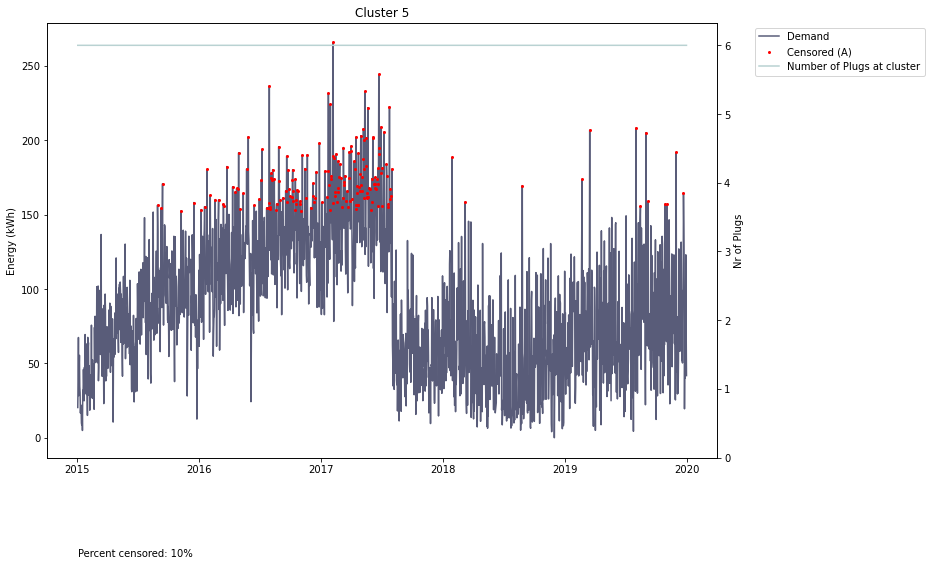

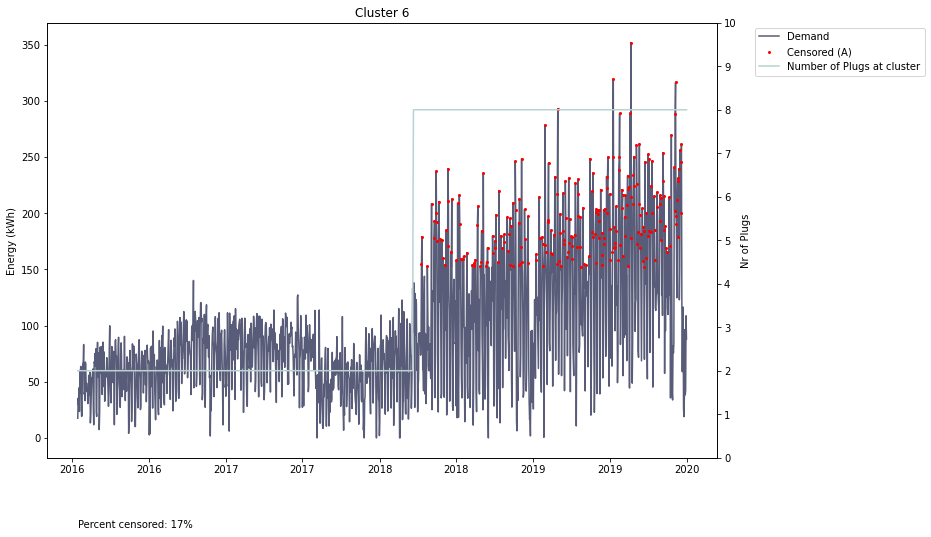

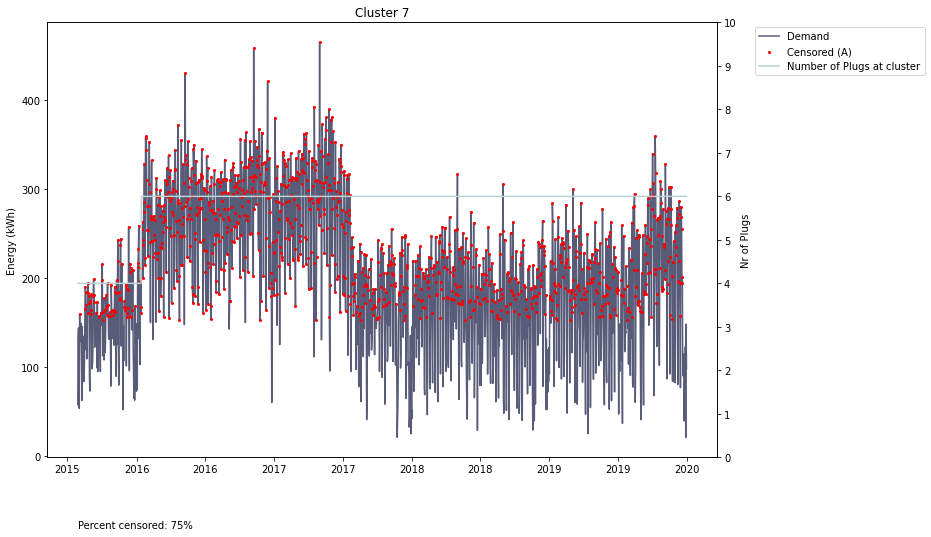

In [84]:
#plt.plot[ww[ww['Label'] == 0]['Energy (kWh)']]
#plt.show()
#la = 5

#for ix, la in enumerate(np.sort((df_final_censoredB['Label'].unique()))):

for la in range(len(df_final_censoredA['Label'].unique())):
    dftemp = df_final_censoredA[df_final_censoredA['Label'] == la]
    #dftemp = dfla[(dfla['Energy (kWh)'] != 0).cumsum() > 0]

    percent_censored = round(100 * (len(dftemp[(dftemp['Censored'] == True)])) / len(dftemp))
    textx = dftemp['Date'].min()

    
    fig, ax = plt.subplots(figsize = (12,8))
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.plot(dftemp['Date'], dftemp['Energy (kWh)'], zorder=0, color = cmap(0.4), label = 'Demand')
    ax.scatter(dftemp[(dftemp['Censored'] == True)]['Date'], dftemp[(dftemp['Censored'] == True)]['Energy (kWh)'], color = 'red', alpha = 1, s = 4,  label = 'Censored (A)') #

    
    ax.set_ylabel('Energy (kWh)')
    #ax.vlines(dftemp[dftemp['Fee (USD)_x'] != 0]['Date'].min(), ymin = -3, ymax = dftemp['Energy (kWh)_x'].max(), color = 'yellow', label="Fee is introduced")

    handlesax, labelsax = ax.get_legend_handles_labels()

    
    ax2 = ax.twinx() 
    #ax2.plot(dftemp.index, dftemp['Plugs'])
    ax2.plot(dftemp['Date'], dftemp['Plugs'], color = cmap(0.8), label = 'Number of Plugs at cluster')

    
    #ax2.plot(dftemp.index, dftemp['Number of NEMA 5-20R'], color = 'yellow')

    ax2.set_ylabel('Nr of Plugs')
    yint = range(0, math.ceil(max(dftemp['Plugs_raw']))+1) #math.floor(min(dftemp['Plugs']))
    ax2.set_yticks(yint)
    
    ax2.title.set_text(f"Cluster {la}")
    handlesax2, labelsax2 = ax2.get_legend_handles_labels()

    #ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    #((ww[ww['Label'] == la]['Energy (kWh)'] - ww[ww['Label'] == la]['Energy (kWh)'].mean())/ ww[ww['Label'] == la]['Energy (kWh)'].std()).plot(label = "Standardized consumption")
    #(ww[ww['Label'] == la]['Plugs']).plot(label = "Nr of plugs")
    #plt.vlines(ww[ww['Fee (USD)'] != 0].index.min(), ymin = -3, ymax = ww[ww['Label'] == la]['Plugs'].max(), color = 'red', label="Fee is introduced")
    #plt.title(f"Label: {la}")
    #plt.legend()
    handles = handlesax + handlesax2
    labels = labelsax + labelsax2
    
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.text(textx, -80, f"Percent censored: {percent_censored}%")

    plt.show()
